# Del 1: Pandas - Time Series

Pripravimo datasete:

In [1]:
!tar -xJf data/data_del_01.tar.xz -C ./data/

Viri:
- [Tutorial: Time Series Analysis with Pandas](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)
- [Working with Time Series](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
- [Modern Pandas (Part 7): Timeseries](https://tomaugspurger.github.io/modern-7-timeseries)
- [Time series / date functionality](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

In [2]:
import numpy as np
import pandas as pd

## The data

<p>In this tutorial, we’ll be working with daily time series of <a href="https://open-power-system-data.org/">Open Power System Data (OPSD)</a> for Germany, which has been <a href="https://www.independent.co.uk/environment/renewable-energy-germany-six-months-year-solar-power-wind-farms-a8427356.html">rapidly expanding its renewable energy production in recent years</a>. The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can download the data <a href="https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv">here</a>.</p>

<p>Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:</p>

<ul>
<li><code>Date</code> — The date (<em>yyyy-mm-dd</em> format)</li>
<li><code>Consumption</code> — Electricity consumption in GWh</li>
<li><code>Wind</code> — Wind power production in GWh</li>
<li><code>Solar</code> — Solar power production in GWh</li>
<li><code>Wind+Solar</code> — Sum of wind and solar power production in GWh</li>
</ul>

### Getting the data

In [3]:
# Ta del zaganjamo samo, če bi hoteli prevzeti še kakšne dodatne podatke, sicer ne

Getting the data from: https://data.open-power-system-data.org/time_series/2018-06-30

In [ ]:
# če bi hoteli prevzeti še kakšne dodatne podatke

#Download hourly data from OPSD website
url = 'https://data.open-power-system-data.org/time_series/2018-06-30/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)
df_all.head()

In [ ]:
df_all.info(memory_usage='deep')

In [ ]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""
    
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
        
    return df_out

In [ ]:
# Extract data for Germany, for complete years 2006-2017 
# (exclude incomplete years 2005 and 2018)
df_hrly = extract_country(df_all, country_code='DE', year_min=2006, year_max=2017)

# Rename columns for convenience
cols_map = {'load_entsoe_power_statistics' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df_hrly = df_hrly[list(cols_map.keys())].rename(columns=cols_map)

# Compute wind + solar generation
df_hrly['Wind+Solar'] = df_hrly[['Wind', 'Solar']].sum(axis=1, skipna=False)

# Convert from MW to GW
df_hrly = df_hrly / 1000
df_hrly.head()

In [ ]:
# Compute daily totals in GWh
df_daily = df_hrly.resample('D').sum(min_count=24)
df_daily = df_daily.rename_axis('Date')
df_daily.head()

In [ ]:
df_daily.to_csv('data/INPUT_opsd_germany_daily.csv')

## Time series data structures

In [4]:
# analizirali bomo kdaj je bila največja in najmanjša poraba, kako se spreminja proizvodnja sončne in vetrne
# energije skozi leto itd.

In [5]:
time = '2018-01-15 03:45pm'

In [6]:
#ta string pretvorimo v timestamp, da ga Python razume
pd.to_datetime(time)

Timestamp('2018-01-15 15:45:00')

In [9]:
pd.to_datetime('7/8/2019 14:15:56', dayfirst=False)

Timestamp('2019-07-08 14:15:56')

In [14]:
# Datetimeindex object nam pomaga pri pretvorbi serije stringov v datume


In [15]:
dates = ['2018-01-05', '7/8/1952', 'Oct 10, 1995']

In [16]:
pd.to_datetime(dates)

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

In [17]:
# format datetime64 shrani vsak datum kot 64-bitni integer. Tako dela hitreje

<p>The following table, drawn from the <a href="http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html">NumPy datetime64 documentation</a>, lists the available format codes along with the relative and absolute timespans that they can encode:</p>

<table>
<thead><tr>
<th>Code</th>
<th>Meaning</th>
<th>Time span (relative)</th>
<th>Time span (absolute)</th>
</tr>
</thead>
<tbody>
<tr>
<td><code>Y</code></td>
<td>Year</td>
<td>± 9.2e18 years</td>
<td>[9.2e18 BC, 9.2e18 AD]</td>
</tr>
<tr>
<td><code>M</code></td>
<td>Month</td>
<td>± 7.6e17 years</td>
<td>[7.6e17 BC, 7.6e17 AD]</td>
</tr>
<tr>
<td><code>W</code></td>
<td>Week</td>
<td>± 1.7e17 years</td>
<td>[1.7e17 BC, 1.7e17 AD]</td>
</tr>
<tr>
<td><code>D</code></td>
<td>Day</td>
<td>± 2.5e16 years</td>
<td>[2.5e16 BC, 2.5e16 AD]</td>
</tr>
<tr>
<td><code>h</code></td>
<td>Hour</td>
<td>± 1.0e15 years</td>
<td>[1.0e15 BC, 1.0e15 AD]</td>
</tr>
<tr>
<td><code>m</code></td>
<td>Minute</td>
<td>± 1.7e13 years</td>
<td>[1.7e13 BC, 1.7e13 AD]</td>
</tr>
<tr>
<td><code>s</code></td>
<td>Second</td>
<td>± 2.9e12 years</td>
<td>[ 2.9e9 BC, 2.9e9 AD]</td>
</tr>
<tr>
<td><code>ms</code></td>
<td>Millisecond</td>
<td>± 2.9e9 years</td>
<td>[ 2.9e6 BC, 2.9e6 AD]</td>
</tr>
<tr>
<td><code>us</code></td>
<td>Microsecond</td>
<td>± 2.9e6 years</td>
<td>[290301 BC, 294241 AD]</td>
</tr>
<tr>
<td><code>ns</code></td>
<td>Nanosecond</td>
<td>± 292 years</td>
<td>[ 1678 AD, 2262 AD]</td>
</tr>
<tr>
<td><code>ps</code></td>
<td>Picosecond</td>
<td>± 106 days</td>
<td>[ 1969 AD, 1970 AD]</td>
</tr>
<tr>
<td><code>fs</code></td>
<td>Femtosecond</td>
<td>± 2.6 hours</td>
<td>[ 1969 AD, 1970 AD]</td>
</tr>
<tr>
<td><code>as</code></td>
<td>Attosecond</td>
<td>± 9.2 seconds</td>
<td>[ 1969 AD, 1970 AD]</td>
</tr>
</tbody>
</table>

<p>For the types of data we see in the real world, a useful default is <code>datetime64[ns]</code>, as it can encode a useful range of modern dates with a suitably fine precision.</p>

In [18]:
dates = ['2/25/10', '8/6/17', '12/15/12']

In [21]:
# če so vsi datumi v isti obliki, je bolje ne uporabiti pd-to_datetime(dates), ker ta za vsako vrednost preverja format
# zato damo še en parameter "format", ki stvar pohitri
pd.to_datetime(dates, format='%m/%d/%y')

DatetimeIndex(['2010-02-25', '2017-08-06', '2012-12-15'], dtype='datetime64[ns]', freq=None)

## Creating a time series DataFrame

In [22]:
opsd_daily = pd.read_csv('data/opsd_germany_daily.csv')

In [23]:
opsd_daily.shape

(4383, 5)

In [24]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [25]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


Next, let’s check out the data types of each column.



In [26]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

In [27]:
# date pretvorimo v tip datetime, da bo hitreje in bolj optimalno
opsd_daily['Date']=pd.to_datetime(opsd_daily['Date'], format = '%Y-%m-%d')

In [28]:
opsd_daily.dtypes

Date           datetime64[ns]
Consumption           float64
Wind                  float64
Solar                 float64
Wind+Solar            float64
dtype: object

In [31]:
# kot indeks je najbolje imeti datum oz. čas. Zato ga damo kot index
opsd_daily = opsd_daily.set_index('Date')

In [32]:
opsd_daily.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN
2006-01-04,1457.217,NaN,NaN,NaN
2006-01-05,1477.131,NaN,NaN,NaN


In [34]:
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

<p>Alternatively, we can consolidate the above steps into a single line, using the <code>index_col</code> and <code>parse_dates</code> parameters of the <code>read_csv()</code> function. This is often a useful shortcut.</p>

```python
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)
```

In [36]:
# dostop do posameznih gradnikov datuma
opsd_daily.index.year

Int64Index([2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006, 2006,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='Date', length=4383)

In [37]:
# Add columns with year, month, and weekday name
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
opsd_daily['Weekday Name'] = opsd_daily.index.weekday_name

In [39]:
# 5 naključnih vzorcev iz dataseta
opsd_daily.sample(5, random_state = 0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,Saturday
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,Thursday
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,Thursday
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,Friday
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,Tuesday


## Time-based indexing

In [41]:
# izpis vrstice na en določen datum
opsd_daily.loc['2017-08-10']

Consumption      1351.49
Wind             100.274
Solar              71.16
Wind+Solar       171.434
Year                2017
Month                  8
Weekday Name    Thursday
Name: 2017-08-10 00:00:00, dtype: object

In [42]:
# izpis vrstice znotraj časovnega območja
opsd_daily.loc['2017-08-10':'2017-08-16']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2017-08-10,1351.491,100.274,71.160,171.434,2017,8,Thursday
2017-08-11,1329.039,108.577,42.198,150.775,2017,8,Friday
2017-08-12,1121.458,305.908,80.906,386.814,2017,8,Saturday
2017-08-13,1025.070,101.266,141.157,242.423,2017,8,Sunday
2017-08-14,1305.341,136.416,201.027,337.443,2017,8,Monday
2017-08-15,1333.398,182.064,172.205,354.269,2017,8,Tuesday
2017-08-16,1364.029,68.592,150.677,219.269,2017,8,Wednesday


In [46]:
# cel mesec (parser string indexing). Lahko tudi celo leto ipd.
opsd_daily.loc['2012-02']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2012-02-01,1511.866,199.607,43.502,243.109,2012,2,Wednesday
2012-02-02,1563.407,73.469,44.675,118.144,2012,2,Thursday
2012-02-03,1563.631,36.352,46.510,82.862,2012,2,Friday
2012-02-04,1372.614,20.551,45.225,65.776,2012,2,Saturday
2012-02-05,1279.432,55.522,54.572,110.094,2012,2,Sunday
2012-02-06,1574.766,34.896,55.389,90.285,2012,2,Monday
2012-02-07,1615.078,100.312,19.867,120.179,2012,2,Tuesday
2012-02-08,1613.774,93.763,36.930,130.693,2012,2,Wednesday
2012-02-09,1591.532,132.219,19.042,151.261,2012,2,Thursday


## Visualizing time series data

In [47]:
# Display figures inline in Jupyter notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

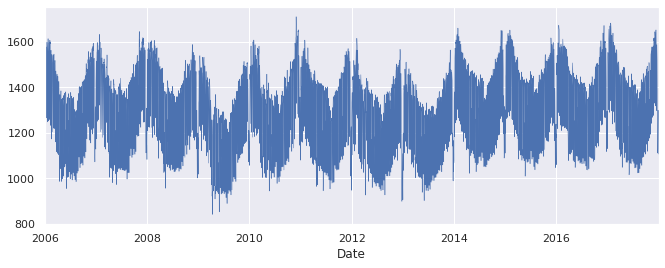

In [51]:
# v enem grafu za celotno obdobje prikažemo kako se spreminja poraba elektrike
opsd_daily['Consumption'].plot(linewidth = 0.5)
plt.show()

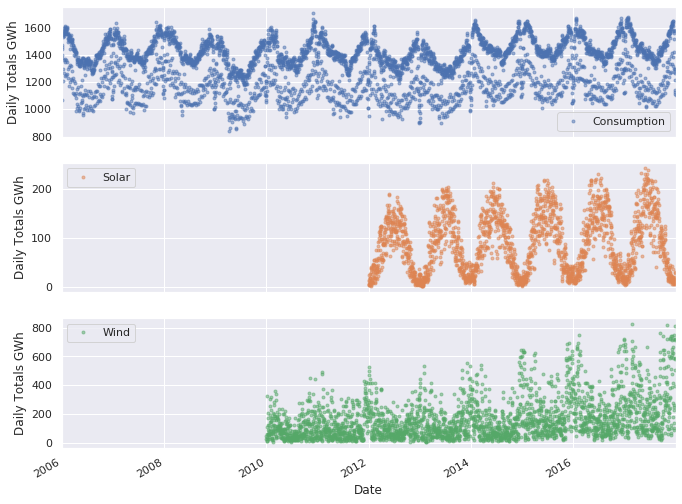

In [53]:
# namesto črk uporabimo pike, zraven pa še solar in wind
cols_plot = ['Consumption', 'Solar', 'Wind']

axes = opsd_daily[cols_plot].plot(marker= '.',
                                 alpha = 0.5,
                                 linestyle = 'none',
                                 figsize = (11,9),
                                 subplots = True)
# na y osi naj piše, da je to "daily totals GWh" za vse tri grafe naenkrat
for ax in axes:
    ax.set_ylabel('Daily Totals GWh')
plt.show()

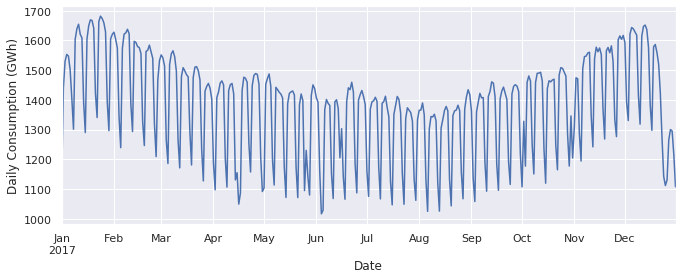

In [55]:
# poglejmo za 2017 
ax = opsd_daily.loc['2017','Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

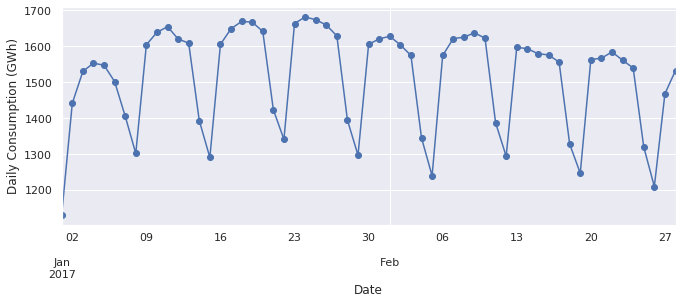

In [56]:
# poglejmo januar in februar
ax = opsd_daily.loc['2017-01':'2017-02','Consumption'].plot(marker = 'o', linestyle = '-')
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

In [ ]:
# če bi dali major ticks na začetke tedna


In [ ]:

ax.set_ylabel('Daily Consumption (GWh)')


In [ ]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption']
ax.set_ylabel('Daily Consumption (GWh)')
plt.show()

## Customizing time series plots

In [57]:
import matplotlib.dates as mdates

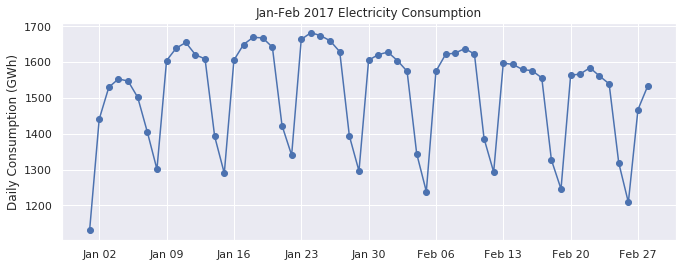

In [59]:


fig, ax = plt.subplots()
ax.plot(opsd_daily.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')

# če bi dali major ticks na začetek tedna
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.show()

## Seasonality

- [Understanding Boxplots](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)
- [Trend, Seasonality, Moving Average, Auto Regressive Model : My Journey to Time Series Data with Interactive Code](https://towardsdatascience.com/trend-seasonality-moving-average-auto-regressive-model-my-journey-to-time-series-data-with-edc4c0c8284b)
- [Seasonality](https://en.wikipedia.org/wiki/Seasonality)

<img src="images/1_NRlqiZGQdsIyAu0KzP7LaQ.png">

**Python zip**

In [62]:
# zip funkcija združi dve listi v list tuppleov
numberList = [1, 2, 3]
strList = ['one', 'two', 'three']

list(zip(numberList, strList))

[(1, 'one'), (2, 'two'), (3, 'three')]

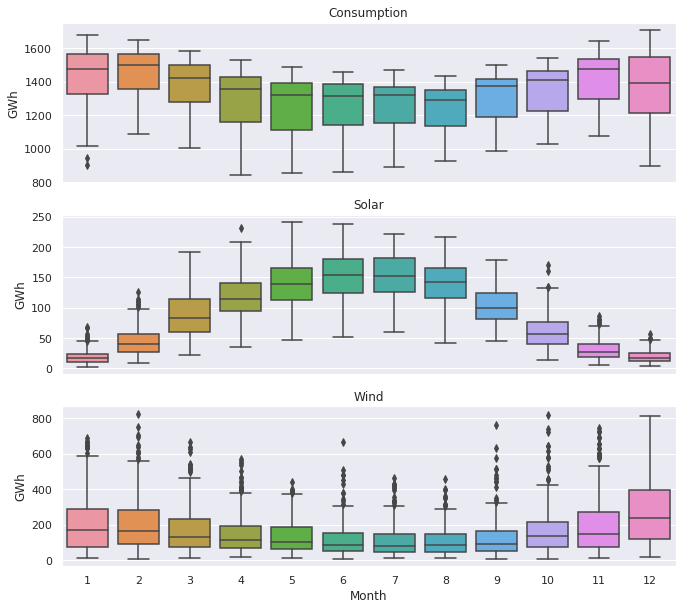

In [64]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['Consumption', 'Solar', 'Wind'], axes):
    
    sns.boxplot(data=opsd_daily, x='Month', y = name, ax= ax)
    
    
    ax.set_ylabel('GWh')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')
plt.show()    

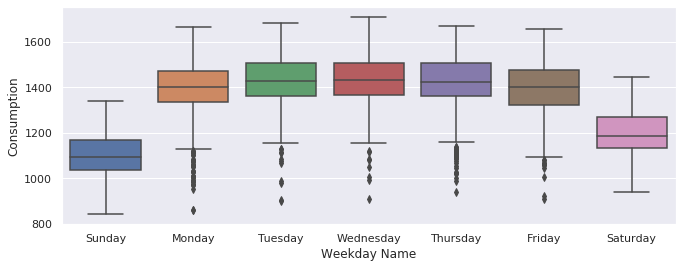

In [72]:
sns.boxplot(data = opsd_daily, x = 'Weekday Name', y=  'Consumption')
plt.show()

In [67]:
opsd_daily.head()

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Weekday Name
Date,,,,,,,
2006-01-01,1069.184,NaN,NaN,NaN,2006,1,Sunday
2006-01-02,1380.521,NaN,NaN,NaN,2006,1,Monday
2006-01-03,1442.533,NaN,NaN,NaN,2006,1,Tuesday
2006-01-04,1457.217,NaN,NaN,NaN,2006,1,Wednesday
2006-01-05,1477.131,NaN,NaN,NaN,2006,1,Thursday


## Frequencies

In [76]:
# podatke lahko prikažemo s frekvencami. 
# naredimo dataset z določeno frekvenco
pd.date_range('1998-03-10', '1998-03-21', freq='4D')

DatetimeIndex(['1998-03-10', '1998-03-14', '1998-03-18'], dtype='datetime64[ns]', freq='4D')

In [77]:
# lahko tudi glede na število period
pd.date_range('2004-09-20', periods=8, freq='H')

DatetimeIndex(['2004-09-20 00:00:00', '2004-09-20 01:00:00',
               '2004-09-20 02:00:00', '2004-09-20 03:00:00',
               '2004-09-20 04:00:00', '2004-09-20 05:00:00',
               '2004-09-20 06:00:00', '2004-09-20 07:00:00'],
              dtype='datetime64[ns]', freq='H')

In [79]:
# sam ne zna ugotoviti frekvence, mu moramo povedati
opsd_daily.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

In [80]:
times_sample = pd.to_datetime(['2013-02-03', '2013-02-06', '2013-02-08'])
consum_sample = opsd_daily.loc[times_sample, ['Consumption']].copy()
consum_sample

,Consumption
2013-02-03,1109.639
2013-02-06,1451.449
2013-02-08,1433.098


In [81]:
# ta metoda zna handlati tudi manjkajoče vrednosti - jih napolni z NaN ali naredi nekaj, kar ji mi povemo
consum_freq = consum_sample.asfreq('D')

In [82]:
consum_freq

,Consumption
2013-02-03,1109.639
2013-02-04,NaN
2013-02-05,NaN
2013-02-06,1451.449
2013-02-07,NaN
2013-02-08,1433.098


In [83]:
# napolnimo z zadnjo znano vrednostjo
consum_freq['Consumption - Forward Fill'] = consum_sample.asfreq('D', method = 'ffill')

In [84]:
consum_freq

,Consumption,Consumption - Forward Fill
2013-02-03,1109.639,1109.639
2013-02-04,NaN,1109.639
2013-02-05,NaN,1109.639
2013-02-06,1451.449,1451.449
2013-02-07,NaN,1451.449
2013-02-08,1433.098,1433.098


## Resampling

In [85]:
# sprememba frekvence časovne serije

data_columns = ['Consumption', 'Wind', 'Solar', 'Wind+Solar']
opsd_weekly_mean = opsd_daily[data_columns].resample('W').mean()
opsd_weekly_mean.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184000,NaN,NaN,NaN
2006-01-08,1381.300143,NaN,NaN,NaN
2006-01-15,1486.730286,NaN,NaN,NaN


In [86]:
opsd_weekly_mean.index

DatetimeIndex(['2006-01-01', '2006-01-08', '2006-01-15', '2006-01-22',
               '2006-01-29', '2006-02-05', '2006-02-12', '2006-02-19',
               '2006-02-26', '2006-03-05',
               ...
               '2017-10-29', '2017-11-05', '2017-11-12', '2017-11-19',
               '2017-11-26', '2017-12-03', '2017-12-10', '2017-12-17',
               '2017-12-24', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=627, freq='W-SUN')

In [87]:
opsd_daily.shape

(4383, 7)

In [88]:
opsd_weekly_mean.shape

(627, 4)

In [89]:
# Start and end of the date range to extract
start, end = '2017-01', '2017-06'

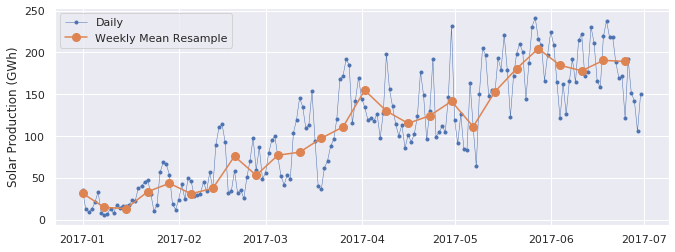

In [90]:
fig, ax = plt.subplots()

ax.plot(opsd_daily.loc[start:end, 'Solar'],
        marker='.', 
        linestyle='-', 
        linewidth=0.5, 
        label='Daily')

ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'], 
        marker='o', 
        markersize=8, 
        linestyle='-', 
        label='Weekly Mean Resample')

ax.set_ylabel('Solar Production (GWh)')
ax.legend()
plt.show()

In [97]:
# če je manj kot 28 vrednosti, naj napolni z NaN-i
# za mesece, kvartale in leta uporablja označbo konca intervala, za vse drugo pa začetek intervala
opsd_monthly = opsd_daily[data_columns].resample('M').sum(min_count = 28)
opsd_monthly.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,45304.704,NaN,NaN,NaN
2006-02-28,41078.993,NaN,NaN,NaN
2006-03-31,43978.124,NaN,NaN,NaN
2006-04-30,38251.767,NaN,NaN,NaN
2006-05-31,38858.143,NaN,NaN,NaN


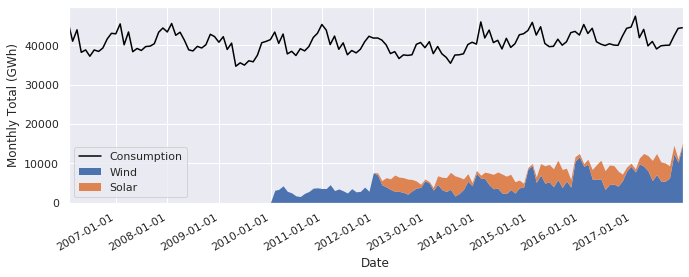

In [98]:
fig, ax = plt.subplots()

ax.plot(opsd_monthly['Consumption'], 
        color='black', 
        label='Consumption')

opsd_monthly[['Wind', 'Solar']].plot.area(ax=ax, linewidth=0)

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_ylabel('Monthly Total (GWh)')
plt.show()

In [99]:
# združimo na letno frekvenco
opsd_annual = opsd_daily[data_columns].resample('A').sum(min_count = 360)

In [100]:
opsd_annual

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-12-31,489068.53600,NaN,NaN,NaN
2007-12-31,496631.84700,NaN,NaN,NaN
2008-12-31,495570.87600,NaN,NaN,NaN
2009-12-31,459737.42800,NaN,NaN,NaN
2010-12-31,488588.70000,35911.777,NaN,NaN
2011-12-31,484814.08600,44032.951,NaN,NaN
2012-12-31,469574.75400,45862.667,27887.332,73749.999
2013-12-31,463336.85300,47197.832,29559.780,76697.443
2014-12-31,504164.82100,51107.672,32498.307,83370.502


In [101]:
# kot indeks damo samo leto namesto zadnjega dneva v letu
opsd_annual = opsd_annual.set_index(opsd_annual.index.year)

In [102]:
opsd_annual

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006,489068.53600,NaN,NaN,NaN
2007,496631.84700,NaN,NaN,NaN
2008,495570.87600,NaN,NaN,NaN
2009,459737.42800,NaN,NaN,NaN
2010,488588.70000,35911.777,NaN,NaN
2011,484814.08600,44032.951,NaN,NaN
2012,469574.75400,45862.667,27887.332,73749.999
2013,463336.85300,47197.832,29559.780,76697.443
2014,504164.82100,51107.672,32498.307,83370.502


In [103]:
opsd_annual.index.name = 'Year'

In [104]:
opsd_annual

,Consumption,Wind,Solar,Wind+Solar
Year,,,,
2006,489068.53600,NaN,NaN,NaN
2007,496631.84700,NaN,NaN,NaN
2008,495570.87600,NaN,NaN,NaN
2009,459737.42800,NaN,NaN,NaN
2010,488588.70000,35911.777,NaN,NaN
2011,484814.08600,44032.951,NaN,NaN
2012,469574.75400,45862.667,27887.332,73749.999
2013,463336.85300,47197.832,29559.780,76697.443
2014,504164.82100,51107.672,32498.307,83370.502


In [105]:
# kako se po letih spreminja razmerje wind in solar
opsd_annual['Wind+Solar/Consumption'] = opsd_annual['Wind+Solar'] / opsd_annual['Consumption']

In [106]:
opsd_annual

,Consumption,Wind,Solar,Wind+Solar,Wind+Solar/Consumption
Year,,,,,
2006,489068.53600,NaN,NaN,NaN,NaN
2007,496631.84700,NaN,NaN,NaN,NaN
2008,495570.87600,NaN,NaN,NaN,NaN
2009,459737.42800,NaN,NaN,NaN,NaN
2010,488588.70000,35911.777,NaN,NaN,NaN
2011,484814.08600,44032.951,NaN,NaN,NaN
2012,469574.75400,45862.667,27887.332,73749.999,0.157057
2013,463336.85300,47197.832,29559.780,76697.443,0.165533
2014,504164.82100,51107.672,32498.307,83370.502,0.165364


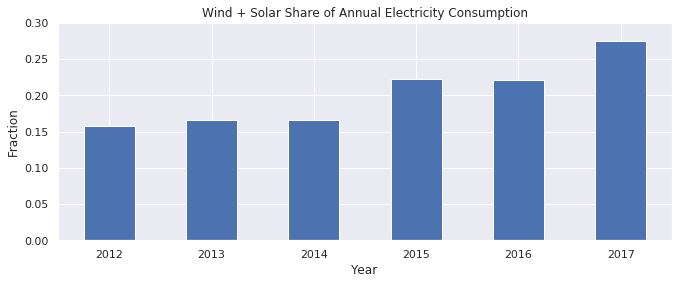

In [107]:
# narišemo v bar graph
ax = opsd_annual.loc[2012:, 'Wind+Solar/Consumption'].plot.bar(color='C0')
ax.set_ylabel('Fraction')
ax.set_ylim(0, 0.3)
ax.set_title('Wind + Solar Share of Annual Electricity Consumption')
plt.xticks(rotation=0)
plt.show()

## Rolling windows

<p><strong>Rolling window</strong> operations are another important transformation for time series data. Similar to downsampling, rolling windows split the data into time windows and and the data in each window is aggregated with a function such as <code>mean()</code>, <code>median()</code>, <code>sum()</code>, etc. However, unlike downsampling, where the time bins do not overlap and the output is at a lower frequency than the input, rolling windows overlap and “roll” along at the same frequency as the data, so the transformed time series is at the same frequency as the original time series.</p>

<img src="images/rollingwindow.png">

<ul>
<li><code>2006-01-01</code> to <code>2006-01-07</code> — labelled as <code>2006-01-04</code></li>
<li><code>2006-01-02</code> to <code>2006-01-08</code> — labelled as <code>2006-01-05</code></li>
<li><code>2006-01-03</code> to <code>2006-01-09</code> — labelled as <code>2006-01-06</code></li>
<li>and so on…</li>
</ul>

In [108]:
opsd_7d = opsd_daily[data_columns].rolling(7, center = True).mean()
opsd_7d.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,1361.471429,NaN,NaN,NaN
2006-01-05,1381.300143,NaN,NaN,NaN


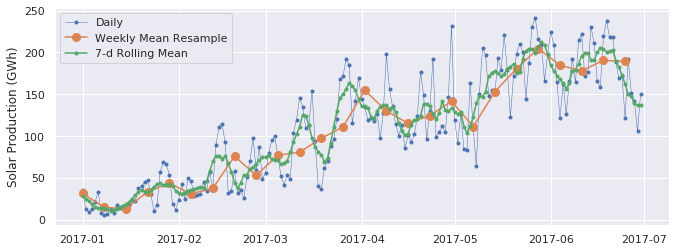

In [109]:
start, end = '2017-01', '2017-06'

fig, ax = plt.subplots()

ax.plot(opsd_daily.loc[start:end, 'Solar'], 
        marker='.', 
        linestyle='-', 
        linewidth=0.5, 
        label='Daily')

ax.plot(opsd_weekly_mean.loc[start:end, 'Solar'], 
        marker='o', 
        markersize=8, 
        linestyle='-', 
        label='Weekly Mean Resample')

ax.plot(opsd_7d.loc[start:end, 'Solar'], 
        marker='.', 
        linestyle='-', 
        label='7-d Rolling Mean')

ax.set_ylabel('Solar Production (GWh)')
ax.legend()
plt.show()

## Trends

In [110]:
opsd_365d = opsd_daily[data_columns].rolling(window=365, 
                                             center=True, 
                                             min_periods=360).mean()

In [112]:
opsd_365d.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,NaN,NaN,NaN,NaN
2006-01-02,NaN,NaN,NaN,NaN
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,NaN,NaN,NaN,NaN
2006-01-05,NaN,NaN,NaN,NaN


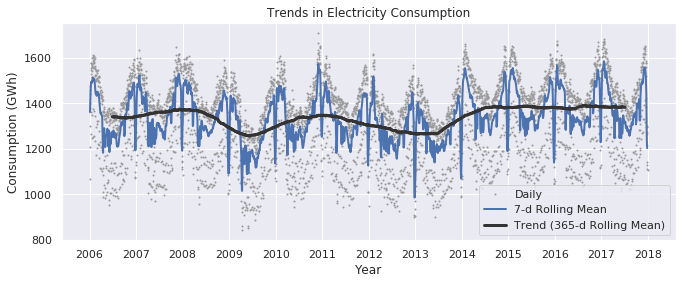

In [113]:
# Plot daily, 7-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()

ax.plot(opsd_daily['Consumption'], 
        marker='.', 
        markersize=2, 
        color='0.6',
        linestyle='None', 
        label='Daily')

ax.plot(opsd_7d['Consumption'], 
        linewidth=2, 
        label='7-d Rolling Mean')

ax.plot(opsd_365d['Consumption'], 
        color='0.2', 
        linewidth=3,
        label='Trend (365-d Rolling Mean)')

# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Consumption (GWh)')
ax.set_title('Trends in Electricity Consumption')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

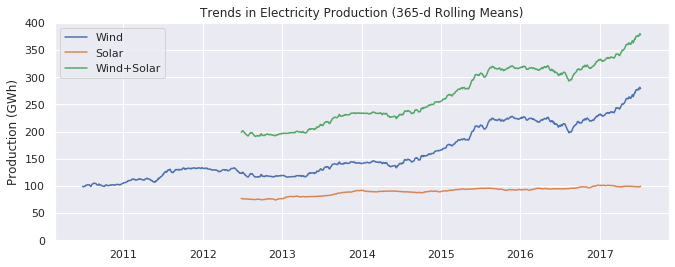

In [115]:
# Plot 365-day rolling mean time series of wind and solar power
fig, ax = plt.subplots()

for nm in ['Wind', 'Solar', 'Wind+Solar']:
    ax.plot(opsd_365d[nm], label = nm)

# Set x-ticks to yearly interval, adjust y-axis limits, add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.set_ylim(0, 400)
ax.legend()
ax.set_ylabel('Production (GWh)')
ax.set_title('Trends in Electricity Production (365-d Rolling Means)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()